# Dimensionality Reduction

An essential part of our analysis toolkit is **dimensionality reduction**. We can now record from 100s or 1000s neurons, even different parts of a neuron. Visualizing this kind of high-dimensional data (many measurements over time) is difficult. If we could find ways to reduce the dimensionality of this dataset, we might be able to visualize the relationships of the dimensions, and in some cases, might need to to make some analysis algorithms work.

Questions that might arise:
- Is there a way to reduce the dimensionality of this dataset without discarding useful information?
- What do these neurons have in common? Are their signals pretty independent, or can we find a useful summary of their activity?
- Even if it's possible to use encode/decode modeling to find task-relevant signals, is that the main thing the neural population is computing about? Can we extract the most important signals driving the population's activity?

Example: Consider modeling the propagation of electric charge down an axon. While the axon resides in a 3-dimensional space, we can still make useful predictions about charge propagation by considering the axon [a cable](https://en.wikipedia.org/wiki/Cable_theory). So, instead of being concerned with how charge propagates in 3 dimensions, we can simply focus on the dimension that corresponds to position along the axon.

# Principal Components Analysis

One of the simplest and most useful approaches to dimensionality reduction is **Principal Components Analysis** (PCA).

**In PCA, we look for orthogonal vectors (that we call Principal Components, or PCs) that explain the most variance in the dataset.**

Let's unpack that sentence. When two vectors are orthogonal, they are perpendicular (at right angles) to each other. This also means the length of the projection of one onto another is 0. So each PC explains different directions in the dataset, with no overlapping directions between them.

For some vector $z$ with length $m$ and mean $\mu_z$, the variance is $Var(z) = \frac{1}{m} \sum_i \left(z_i - \mu_z\right)^2$. If we assume vector $z$ is centered so $\mu_z=0$ (we can accomplish this by subtractig the mean beforehand), then that simplifies to

$$Var(z)=\frac{1}{m} \sum_i z_i^2=\frac{1}{m} \|z\|_2^2$$

since $\|z\|_2=\sqrt{ \sum_i z_i^2 }$. We'll assess how well a vector explains variance by computing the variance of our dataset projected onto that vector.

So, our first PC is the vector in the direction of highest variance of the dataset. Our second PC is a vector orthogonal to the first in the direction of highest variance. We can use this process to find each PC, finding the direction of highest variance orthogonal to prior ones.

# Our first PC

Let's make that a little more concrete by finding the first PC for a dataset. Let's say we have a dataset $X$ with size $m \times n$, where $m$ is the number of samples we have (say, number of time points of recorded neural activity) and $n$ is the number of features we have (say, number of recorded nuerons). We're trying to summarize this data, collapsing across neurons to find the common patterns across their activity. In math, we want to find a PC $w$ of length $n$ in the direction of highest variance of our dataset $X$. We'll do this by finding a $w$ that maximizes $Var(Xw)$, the variance of the data $X$ projected onto $w$. So, our optimization objective is

$$\arg \max_w \frac{1}{m}\|Xw\|^2_2$$

Here's a randomly generated dataset:

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

(20, 2)


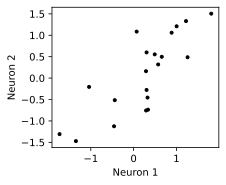

In [21]:
# First, randomly generate data
np.random.seed(42)
X = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, .85], [.85, 1]]), size=20)
print(X.shape)

# Plot data
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(*X.T, '.k')
ax.set(
    aspect='equal',
    xlabel='Neuron 1',
    ylabel='Neuron 2',
);


We'll pretend this is a dataset recording from two neurons during trials of a task. We'll also pretend each point represents neural activity for each trial. From a quick look, it seems like the two neurons have very correlated activity, and may be well-explained by a single PC.

So, let's do a PCA! We'll build this one up from scratch. Each neuron has mean of roughly zero, so we'll skip centering. We'll define the variance of a vector, and do grid search to find the best one. In grid search, we enumerate possibilities and select the best, so we'll take the vector in each direction, compute the variance, and report the best.

In [22]:
# First we define a function for the variance.
def Var(z):
    return (z.T@z)/z.shape[0]

# For each direction, we'll define the vector $w$ and compute the $Var(Xw)$.
ws = []
vars = []
for theta in np.arange(0, 2*np.pi, np.pi/16):
    w = np.array([np.sin(theta), np.cos(theta)])
    ws.append(w)
    vars.append(Var(X@w))

# Now we'll find the best one.
best = np.argmax(vars)
pc1 = ws[best]
print('Best vector', pc1, 'has Var()', vars[best])

Best vector [-0.70710678 -0.70710678] has Var() 1.435179832557378


We can also see the variance for each choice of vector:

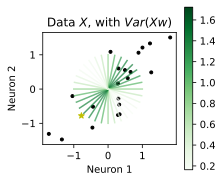

In [23]:
# Plot data
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(*X.T, '.k')
ax.set(
    aspect='equal',
    xlabel='Neuron 1',
    ylabel='Neuron 2',
    title='Data $X$, with $Var(Xw)$'
)

sm = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=min(vars), vmax=max(vars)*1.2),
    cmap=plt.get_cmap('Greens'))
f.colorbar(sm)

ax.scatter([pc1[0]*1.1], [pc1[1]*1.1], marker='*', c='y')
for w, var in zip(ws, vars):
    ax.plot([0, w[0]], [0, w[1]], c=sm.to_rgba(var), alpha=0.7)

# The second PC

We want our second PC to be orthogonal to the first. Since we only have 2 dimensions, that is enough to define our second PC. However, we'll go through the process briefly since it's useful for thinking about data with more dimensions.

First, we'll project our data to the 1st PC. Below, you can see the PC (black line), original data (black points), and projected data (red points). To compute the projection, we first find the length of the projection for each data point $Xw$, then use that length to scale the principal component. So, the red points are $(Xw)w^T$. We can think of them as the best 1-dimensional reconstruction of the original data.

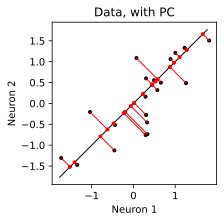

In [24]:
# Plot data
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(*X.T, '.k')
ax.set(
    aspect='equal',
    xlabel='Neuron 1',
    ylabel='Neuron 2',
    title='Data, with PC'
)

lim = 2.5
ax.plot([-lim*pc1[0], lim*pc1[0]], [-lim*pc1[1], lim*pc1[1]], '-k', lw=1)

for el in X:
    loading = el @ pc1
    elproj = loading * pc1
    plt.plot([el[0], elproj[0]], [el[1], elproj[1]], '-r', lw=1)
    plt.plot(elproj[0], elproj[1], '.r')#, fillstyle='none')

Since our 2nd PC needs to be orthogonal to the first, we'll subtract the projected dataset from the original, so we'll find the principal component of $X-(Xw)w^T$. First we'll visualize the data without the first PC.

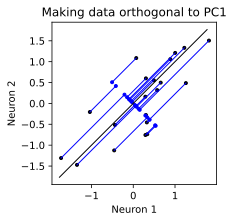

In [25]:
# We define X without first PC
XwithoutPC1 = X - (X@pc1)[:, None] * pc1[None, :]

# Plot data
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(*X.T, '.k')
ax.plot(*XwithoutPC1.T, '.b')
ax.set(
    aspect='equal',
    xlabel='Neuron 1',
    ylabel='Neuron 2',
    title='Making data orthogonal to PC1'
)

lim = 2.5
ax.plot([-lim*pc1[0], lim*pc1[0]], [-lim*pc1[1], lim*pc1[1]], '-k', lw=1)

for el, elproj in zip(X, XwithoutPC1):
    plt.plot([el[0], elproj[0]], [el[1], elproj[1]], '-b', lw=1)

Now, we'll do grid search to find our 2nd PC.

In [26]:
# For each direction, we'll define the vector $w$ and compute the $Var(Xw)$.
ws = []
vars = []
for theta in np.arange(0, 2*np.pi, np.pi/16):
    w = np.array([np.sin(theta), np.cos(theta)])
    ws.append(w)
    vars.append(Var(XwithoutPC1@w))

# Now we'll find the best one.
best = np.argmax(vars)
pc2 = ws[best]
print('Best vector', pc2, 'has Var()', vars[best])

Best vector [-0.70710678  0.70710678] has Var() 0.16351933703794588


We'll take a look now at the data without the first PC and see what the best second PC is.

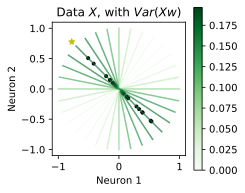

In [27]:
# Plot data
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(*XwithoutPC1.T, '.k')
ax.set(
    aspect='equal',
    xlabel='Neuron 1',
    ylabel='Neuron 2',
    title='Data $X$, with $Var(Xw)$'
)

sm = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=min(vars), vmax=max(vars)*1.2),
    cmap=plt.get_cmap('Greens'))
f.colorbar(sm)

ax.scatter([pc2[0]*1.1], [pc2[1]*1.1], marker='*', c='y')

for w, var in zip(ws, vars):
    ax.plot([0, w[0]], [0, w[1]], c=sm.to_rgba(var), alpha=0.7)

To find other PCs (in a higher-dimensional dataset), you'd simply repeat the steps above. In practice, you'll use methods like SVD, eigendecomposition, or a library that does PCA itself, but we hope this exposition will help you understand what those methods are producing.

One closing note: This exposition highlights that PCs explain the most variance in the original dataset. Another equivalent view is that PCs give you a reconstruction that has minimal error.

# In Practice

The simplest way to compute a PCA in practice might use some library that solves the problem. For most practical uses, you might want to use `sklearn`'s version.

In [28]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

for i in range(2):
    print('PC', pca.components_[i], 'Var()', pca.explained_variance_[i])

PC [-0.69448318 -0.71950894] Var() 1.4507271870129048
PC [-0.71950894  0.69448318] Var() 0.1609517131108021


We touched on the topic of mean-centering above; it's important for making sure your PCs are interpretable. If your data isn't centered, the first PC may at times be the dataset's average, but there enough caveats (mentioned in this great [StatsExchange post](https://stats.stackexchange.com/a/130565)) that it's worth simply mean-centering yourself.

Thankfully, `sklearn` does mean-centering by default! Check out the [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), relevant piece is:

> Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

We'll briefly note the relationship between PCA and Singular Value Decomposition later on, but I think it's worth appreciating that `sklearn`'s PCA is really simple. [Here's the full code](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/decomposition/_pca.py#L450-L464), which can be boiled down to these lines:

```python
X -= np.mean(X, axis=0)
_, singular_values_, components_ = linalg.svd(X, full_matrices=False)
explained_variance_ = (singular_values_ ** 2) / (n_samples - 1)
```

## How many components to use?

Depends on what you want to do with them! Some try to choose components that are less likely to be noise, by comparing the relative amount of variance explained by each PC. This sort of choice winds up being heuristic; you might look for a component that explains much less than prior ones, or the components necessary to explain some fixed amout of variance. As Alex Williams notes in [this blog post](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/) there are also theoeretically motivated ways to choose the number of components. I'll show an example using a builtin dataset from sklearn.

The largest gap is from the first to second component, but taking the first 6 explains 90% of the variance.

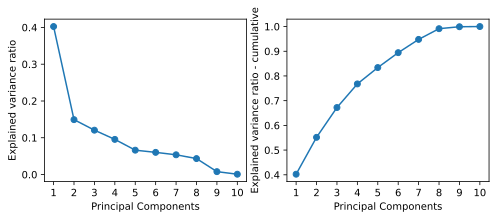

In [29]:
import sklearn.datasets
data = sklearn.datasets.load_diabetes().data
pca = sklearn.decomposition.PCA()
pca.fit(data)
xs = range(1, len(pca.components_)+1)

f, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(xs, pca.explained_variance_ratio_, '-o')
axes[0].set_ylabel('Explained variance ratio')
axes[0].set_xlabel('Principal Components')
axes[0].set_xticks(xs)

axes[1].plot(xs, np.cumsum(pca.explained_variance_ratio_), '-o')
axes[1].set_ylabel('Explained variance ratio - cumulative')
axes[1].set_xlabel('Principal Components')
axes[1].set_xticks(xs);

## Reconstruction

Above, we projected our data back to the first PC, making a low-dimensional approximation of our data. What does this look like in higher dimensions? In this section, we'll walk through figures from [Alex Williams' blog post](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/). On the left you can see the dataset, in the middle the top PC and loadings of each row of the dataset, and on the right the reconstructed dataset. Clearly an approximation, but not bad!

<img src="images/aw-rank1.png" width="80%" />

Now we'll look at a more compliated dataset. Here's the explained variance ratio for each component. It looks like 3-components should give us a good approximation.

<img src="images/aw-scree.png" width="30%" />

Here's the 3-dimensional approximation.

<img src="images/aw-rank3.png" width="80%" />

We'll close this section out with some code that makes similar plots as the above, making low-dimensional approximations of our datasets.

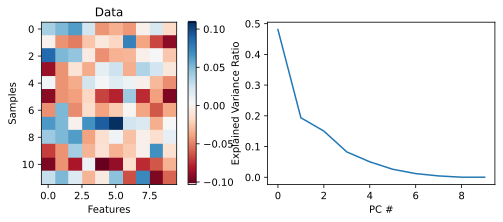

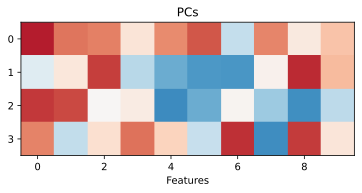

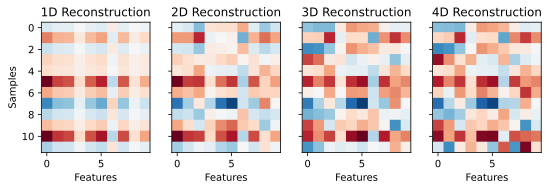

In [30]:
small_data = sklearn.datasets.load_diabetes().data[:12, :10]
kw = dict(vmin=small_data.min(), vmax=small_data.max())

pca = sklearn.decomposition.PCA()
pca.fit(small_data)

cm = plt.get_cmap('RdBu')

f, axes = plt.subplots(1, 2, figsize=(9, 3))
plt.sca(axes[0])
plt.imshow(small_data, cmap=cm, **kw)
plt.title('Data')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.colorbar()

plt.sca(axes[1])
plt.ylabel('Explained Variance Ratio')
plt.xlabel('PC #')
plt.plot(pca.explained_variance_ratio_)

plt.figure()
plt.title('PCs')
plt.xlabel('Features')
lim = max(abs(pca.components_.min()), abs(pca.components_.max()))
plt.imshow(pca.components_[0:4], cmap=cm, vmin=-lim, vmax=lim)

f, axes = plt.subplots(1, 4, figsize=(9, 3), sharex=True, sharey=True)
axes[0].set_ylabel('Samples')
for ndim, ax in zip([1, 2, 3, 4], axes):
    plt.sca(ax)
    recon = np.zeros(small_data.shape)
    for pcidx in range(ndim):
        loading = small_data @ pca.components_[pcidx]
        recon += loading[:, None] * pca.components_[pcidx][None, :]
    plt.imshow(recon, cmap=cm, **kw)
    plt.title('{}D Reconstruction'.format(ndim))
    plt.xlabel('Features')

# How is PCA computed

While we took an optimization approach above, part of PCA's ubiquity and appeal is that it can be efficiently computed using ideas from linear algebra. As you could see from `sklearn`, different linear algebra decompositions can be used to find our PCs.

One of the most commons ways to do a PCA is an eigendecomposition of the covariance matrix:

In [31]:
evals, evecs = np.linalg.eig(np.cov(X.T))
for i in range(2):
    print('PC/Eigenvector', evecs[:, i], 'Var()/Eigenvalue', evals[i])

PC/Eigenvector [-0.71950894  0.69448318] Var()/Eigenvalue 0.16095171311080214
PC/Eigenvector [-0.69448318 -0.71950894] Var()/Eigenvalue 1.4507271870129046


Or to take the Singular Value Decomposition (SVD) of the matrix (which is what `sklearn` does).

(A brief aside: SVD can be preferable over eigendecomposition when you have many more features than samples you are trying to do a PCA on. Eigendecomposition requires computing the covariance of the features, so for large numbers of features can be unwieldly. SVD is likely preferable in that case since it can decompose rectangular data, avoiding the large size of the feature covariance matrix. For a great thread on SVD, check out this [twitter thread of Daniela Witten's](https://twitter.com/WomenInStat/status/1285610321747611653))

In [32]:
U, S, VT = np.linalg.svd(X)
for i in range(2):
    print('PC/singular vectors', VT[:, i], 'singular value', S[i], 'Var()', S[i]**2/X.shape[0])

PC/singular vectors [0.70852281 0.70568792] singular value 5.35758330314973 Var() 1.4351849425094387
PC/singular vectors [ 0.70568792 -0.70852281] singular value 1.8083928062557901 Var() 0.1635142270858846


If you're curious about how `np.linalg.svd` or `np.linalg.eig` are computed, you can visit [wikipedia](https://en.wikipedia.org/wiki/Singular_value_decomposition#Calculating_the_SVD) for the gory details. A theme in many implementations is something called [Power Iteration](https://en.wikipedia.org/wiki/Power_iteration), where you take a random vector, multiply it by your data matrix, normalize the result, and repeat. After many iterations, this will give you the eigenvector of your data matrix. Below is an example of computing the first eigenvector using Power Iteration.

In [33]:
w = np.random.uniform(-1, 1, size=2)
print('Random vector', w)
for _ in range(1000):
    w = np.cov(X.T) @ w
    w = w / np.linalg.norm(w)
print('After power iteration', w)

Random vector [0.93916926 0.55026565]
After power iteration [0.69448318 0.71950894]


# Conclusion

We now know how to employ PCA to perform dimensionality reduction! In your exercise, you'll apply this method to understand a dataset (from Russo et al. 2020). There are many approaches to dimensionality reduction in neural data:

- Russo et al. 2020 and [Gallego et al. 2018](https://www.nature.com/articles/s41467-018-06560-z) both simply use PCA.
- An early paper, [Churchland et al. 2012](https://www.nature.com/articles/nature11129) uses a variant of PCA that is designed for time series.
- More complex and modern approaches like [Low et al. 2018](https://www.biorxiv.org/content/10.1101/418939v2) attempt to unravel the structure in neural manifolds; in their case, they flatten out place cell representations into a map.

# Resources
- [Alex Williams' blog post](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/) on the topic was remarkably helpful for this line of presentation.
- [Daniela Witten's twitter thread on SVD](https://twitter.com/WomenInStat/status/1285610321747611653).
- [Geometric interpretations of PCs](https://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/), something I didn't touch on.
- [A really nice tutorial linked by Alex William](https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf)